In [30]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

In [31]:
df = pd.read_csv('https://gist.githubusercontent.com/singhsidhukuldeep/cc3c9597bce35f5f242a921eb3361c75/raw/54227431f0dc8ac1c438f438e2174d181fdda330/blinkit_multiclass.csv')
df.head()

,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,class
0,3,12669,9656,7561,214,2674,1338,2
1,3,7057,9810,9568,1762,3293,1776,2
2,3,6353,8808,7684,2405,3516,7844,2
3,3,13265,1196,4221,6404,507,1788,1
4,3,22615,5410,7198,3915,1777,5185,1


Data Description

feature	            Description

Region:	            where the store is located (1: Tier-1 city, 2: Tier-2 city, 3:Tier-3 city)

Fresh:	            purchase history of Fresh food

Milk:	            purchase history of milk product

Grocery:	        purchase history of Grocery

Frozen:	            purchase history of Frozen food

Detergents_Paper:	purchase history of washing products

Delicassen:	        purchase history of imported products, cooked meat

class:	            Store catgeory based on demand on products	

<Axes: xlabel='class', ylabel='count'>

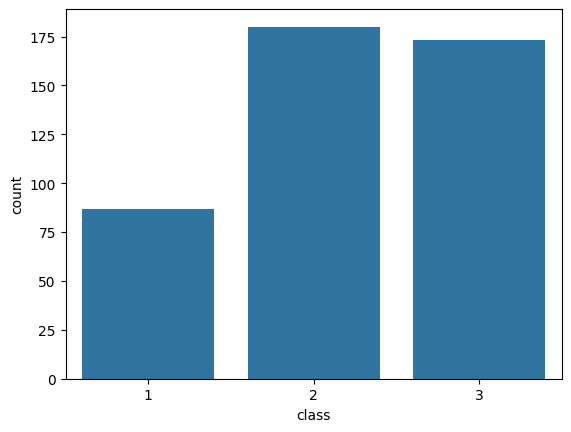

In [32]:
sns.countplot(data = df, x = 'class')

In [33]:
df.columns

Index(['Region', 'Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper',
       'Delicassen', 'class'],
      dtype='object')

In [34]:
X = df[['Region', 'Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper','Delicassen']].copy()
y = df[['class']].copy()

### Let us reduce the feature from 7 to 2

In [35]:
from sklearn.decomposition import PCA
pca = PCA(n_components= 2)
print(X.shape)
X = pca.fit_transform(X)
print(X.shape)

(440, 7)
(440, 2)


25% is test and rest 75% is broken down to train and test

In [36]:
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, 
                                                            y.values[:,0], 
                                                            test_size= 0.25, random_state= 42)

#rest 75% will be split in train and Validation 

X_train, X_val, y_train, y_val = train_test_split(X_train_val, 
                                                  y_train_val, 
                                                  test_size= 0.25, 
                                                  random_state= 42)

In [37]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(247, 2) (247,)
(83, 2) (83,)
(110, 2) (110,)


Anytime we use an algorithm on distance we have to make sure that features are at same scale. so we use standerization
### Standerization

In [38]:
mu = X_train.mean()
sig = X_train.std()

In [39]:
X_train = (X_train-mu)/sig
X_val = (X_val-mu)/sig
X_test = (X_test-mu)/sig

### KNN Algo

In [40]:
def knn(X,Y, queryPoint, k = 5):

    #Euclidean Distance 
    dist = np.sqrt(np.sum((queryPoint-X)**2, axis= 1))
    print('all dist:', dist[:7])

    #Storing distance and Class Labels togather
    distances = [(dist[i], Y[i])for i in range(len(dist))]
    print('Distnaces with labels:', distances[:7])

    #sort the distances 
    distances = sorted(distances, key = lambda x:x[0])
    print('Distances sorted:', distances[:7])

    #Nearest/First K points
    distances = distances[:k]
    print('Distances top k:', distances)

    print(f'k nearest neighbours with the distance and class label:{distances}')

    distances = np.array(distances)

    print('Distances top k as np array:', distances)

    classes_count = np.unique(distances[:,1], return_counts= True)
    print('classes_counts:', classes_count)

    index = classes_count[1].argmax()
    pred = classes_count[0][index]
    print(f"prediction: {pred} at index {index} in classes_counts {classes_count}")

    return int(pred)

# predicting 

print(X_test[50])
print(knn(X_train, y_train, X_test[50], k = 100))


    

[0.14309397 1.18110906]
all dist: [1.94482539 1.5159984  3.58348439 1.89854683 1.53423528 1.01791159
 1.72338532]
Distnaces with labels: [(1.9448253921765362, 2), (1.5159983957549834, 1), (3.5834843874202, 2), (1.8985468272744133, 3), (1.534235283199277, 3), (1.017911593293824, 2), (1.7233853183523948, 3)]
Distances sorted: [(0.1735303171925501, 2), (0.33882408047225804, 2), (0.4080313193575027, 2), (0.41587026707538627, 2), (0.53971431776536, 2), (0.5996182487250811, 2), (0.6045016862791139, 2)]
Distances top k: [(0.1735303171925501, 2), (0.33882408047225804, 2), (0.4080313193575027, 2), (0.41587026707538627, 2), (0.53971431776536, 2), (0.5996182487250811, 2), (0.6045016862791139, 2), (0.6317539993939535, 2), (0.6587608752112633, 2), (0.6826885539435081, 2), (0.7041658434195189, 2), (0.8049957268643527, 2), (0.8614253915676962, 2), (0.8743150291082724, 2), (0.8948641082264043, 2), (0.925148663246564, 2), (0.9333514491225142, 2), (0.9417023569018909, 2), (0.9492379034524128, 2), (0.959